## Compare the counts in both the chrM and the variant regions
### Heatmaps for them. Also do AFs correlate with variants

In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
NUM_DONORS=2
prob_threshold=0.8
INDIR = "./"
config_f = "parameters/jan21_2021.yaml"
OUTDIR='./results/'


In [3]:
# if not os.path.exists(OUTDIR):
#     os.mkdir(OUTDIR)

#os.chdir(INDIR)

In [4]:
import os
from itertools import product
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join, dirname, basename
import numpy as np

In [5]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread

In [6]:
import glob
from src.utils.parse_config import read_config_file
config = read_config_file(config_f)
config

{'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist',
 'variants_f': '/data2/mito_lineage/data/external/cellSNP_variants/processed/liftOver_chr_full_genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf',
 'genome_size': '/data/isshamie/mito_lineage/data/external/GRCh38_MT_blacklist/fasta/genome.chrom.size',
 'use_mt_bam': True,
 'mttrace_dir': '/data2/mito_lineage/data/processed/mttrace/jan21_2021/',
 'prefix': 'jan21_2021',
 'samples': ['P2', 'J2'],
 'N_DONORS': 4,
 'pseudo_multiplex': {'num_cells': 25000, 'is_proportional': False},
 'mt': {'minMAF': [0.01], 'minCOUNT': [200]},
 'pre_variant': {'minMAF': [0.1], 'minCOUNT': [20]}}

In [7]:
ls data/jan21_2021/chrM/

J2_cellSNP_minC200_minAF0.01/  P2_cellSNP_minC200_minAF0.01/  pseudo/


## Loading cellSNP pileup data

In [8]:
def load_mtx_df(in_f, skip_first=True, give_header=False):
    df = pd.read_csv(in_f, comment="%", header=None, sep="\t")
    df.columns = ["Variant", "Cell", "integer"]

    if skip_first:
        head = df.iloc[0]
        df = df.iloc[1:] # Seems to be summary values
    if give_header:
        return df,head
    return df

def load_pileup(indir, use_oth=False):
    curr_dp_f = join(indir, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(indir, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(indir, "cellSNP.tag.OTH.mtx")
    vcf_f = join(indir, "cellSNP.base.vcf")
    if not os.path.exists(vcf_f):
        if not os.path.exists(vcf_f + ".gz"):
            raise ValueError("VCF file not here!")
        else:
            vcf_f = vcf_f + ".gz"
    dp = load_mtx_df(curr_dp_f)
    ad = load_mtx_df(curr_ad_f)
    vcf = pd.read_csv(vcf_f, skiprows=1, sep="\t")
    if os.path.exists(curr_oth_f) and use_oth:
        oth = load_mtx_df(curr_oth_f)
        return dp, ad, oth, vcf
    return dp, ad, vcf

def load_mtx_df_full(in_f, vcf_f=None):
    df = pd.DataFrame(mmread(in_f).tocsc().todense())
    df.index.name = "Variant"
    df.columns.name = "Cell"
    if vcf_f is None:
        return df
    vcf = pd.read_csv(vcf_f, sep='\t', skiprows=1)
    print(f" {in_f} shape {df.shape}")
    df = pd.merge(df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    return df

def load_pileup_full(indir, use_oth=False):
    curr_dp_f = join(indir, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(indir, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(indir, "cellSNP.tag.OTH.mtx")
    curr_barcode_f = join(indir, "cellSNP.samples.tsv")
    vcf_f = join(indir, "cellSNP.base.vcf")
    if not os.path.exists(vcf_f):
        if not os.path.exists(vcf_f + ".gz"):
            raise ValueError("VCF file not here!")
        else:
            vcf_f = vcf_f + ".gz"
    dp = load_mtx_df_full(curr_dp_f, vcf_f)
    ad = load_mtx_df_full(curr_ad_f, vcf_f)
    vcf = pd.read_csv(vcf_f, skiprows=1, sep="\t")
    barcode = pd.read_csv(curr_barcode_f, header=None)[0].values
    if os.path.exists(curr_oth_f) and use_oth:
        oth = load_mtx_df_full(curr_oth_f, load_mtx_df_full)
        return dp, ad, oth, vcf
    return dp, ad, vcf, barcode

### MT

In [9]:
mt_counts = pd.DataFrame(product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]), 
                                columns=["sample", "minCount", "minAF"])
#{"Donor": [], "mt_minAF": [], "mt_minCount":[], "minAF":[], "minCount":[]}
all_ad = {}
all_dp = {}
all_vcf = {}
all_barcodes={}
#for sample, minCount, minAF in product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]):    
for ind, val in mt_counts.iterrows():
    curr_dir = f"data/jan21_2021/chrM/{val['sample']}_cellSNP_minC{val['minCount']}_minAF{val['minAF']}/"
    print(curr_dir)
    dp, ad, vcf, barcode = load_pileup_full(curr_dir)
    all_ad[ind] = ad
    all_dp[ind] = dp
    all_vcf[ind] = vcf
    all_barcodes[ind] = barcode

data/jan21_2021/chrM/P2_cellSNP_minC200_minAF0.01/
 data/jan21_2021/chrM/P2_cellSNP_minC200_minAF0.01/cellSNP.tag.DP.mtx shape (210, 6875)
 data/jan21_2021/chrM/P2_cellSNP_minC200_minAF0.01/cellSNP.tag.AD.mtx shape (210, 6875)
data/jan21_2021/chrM/J2_cellSNP_minC200_minAF0.01/
 data/jan21_2021/chrM/J2_cellSNP_minC200_minAF0.01/cellSNP.tag.DP.mtx shape (201, 12009)
 data/jan21_2021/chrM/J2_cellSNP_minC200_minAF0.01/cellSNP.tag.AD.mtx shape (201, 12009)


In [10]:
mt_counts

,sample,minCount,minAF
0,P2,200,0.01
1,J2,200,0.01


## Look at minAF=0.01 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

## Plot cell depth

In [12]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]


minAF = 0.01
minCount = 200
curr_val = mt_counts[(mt_counts["minAF"] == minAF) & (minCount == mt_counts["minCount"])]

for ind, val in curr_val.iterrows():
    print(all_dp[ind])

                  0     1     2     3     4     5     6     7     8     9     \
#CHROM POS   ALT                                                               
chrM   64    T     120   188    19    99    77    31    28   554    29    20   
       73    A     132   184    21   112    77    40    28   573    27    20   
       146   C      50   111     3    56    28    16    14   238    20     8   
       153   G      54   119     4    61    24    16    10   270    18     7   
       185   A      32   134     3    32    18    10    16   240    15     4   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
       16325 C      76   160    20    81    53    10    10   293    63     6   
       16327 T      81   167    21    92    52    12    12   303    67    10   
       16362 C     113   214    20   101    65    38    32   344    72    12   
       16463 G     121   252    37   135    77    53    32   503    44    20   
       16519 C      74   183    23    97

In [13]:
cell_depth_long = all_dp[0].reset_index().melt(id_vars=["#CHROM", "POS", "ALT"], value_name="Depth")
cell_depth_long= cell_depth_long.rename({"#CHROM":"CHR"}, axis=1)
cell_depth_long["ID"] = cell_depth_long.apply(lambda x: f"{x['CHR']}_{x['POS']}_{x['ALT']}", axis=1)

In [23]:

for ind, val in mt_counts.iterrows()

sample        P2
minCount     200
minAF       0.01
Name: 0, dtype: object

In [ ]:
for x in cell_labels:
    cell_labels[x]["Sample"] = x
    cell_labels[x] = cell_labels[x].rename({0:"CB"}, axis=1)
cell_labels = pd.concat(cell_labels, axis=0).reset_index(drop=True)

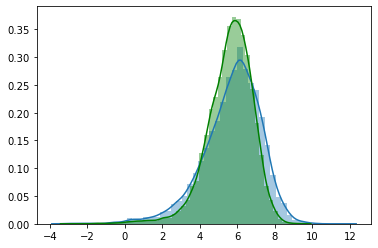

In [31]:
(sns.distplot(np.log2(all_dp[0].mean(axis=0))))
sns.distplot(np.log2(all_dp[1].mean(axis=0)), color='green')

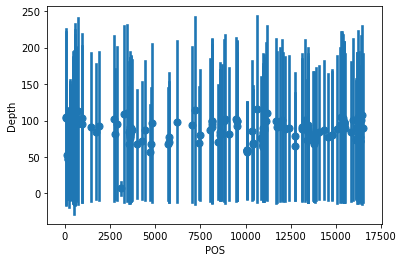

In [15]:
%matplotlib inline
sns.regplot(x="POS", y ="Depth", data=cell_depth_long, x_ci="sd", x_estimator=np.mean, fit_reg=False)

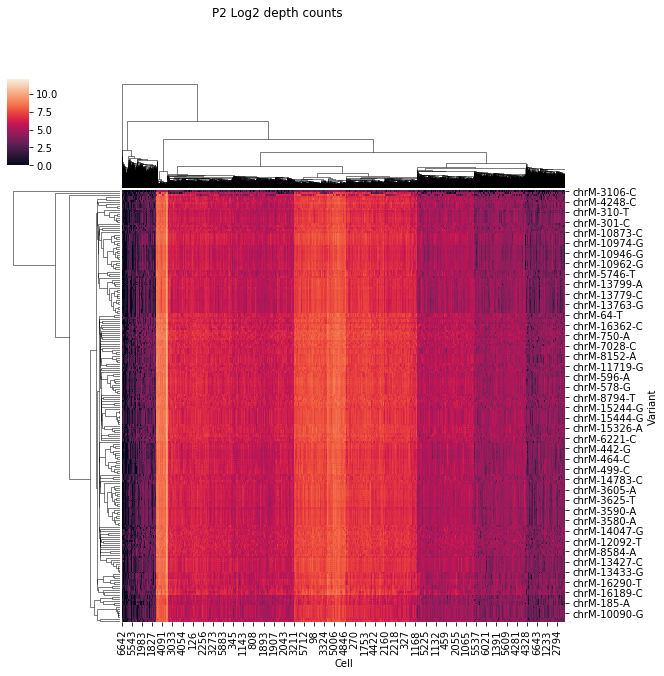

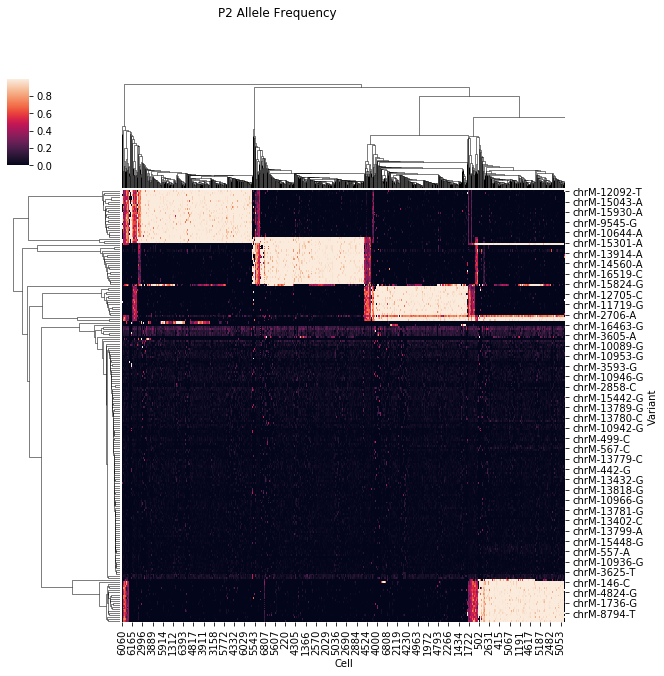

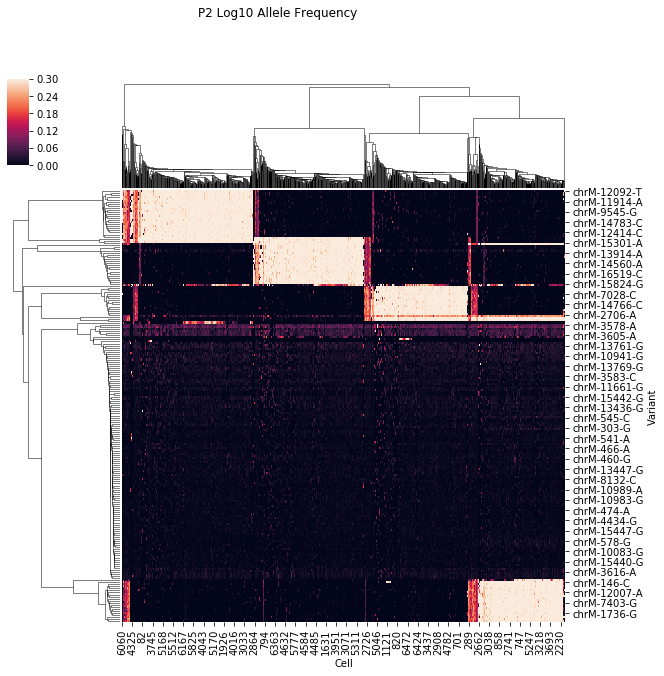

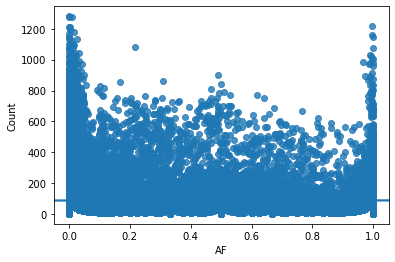

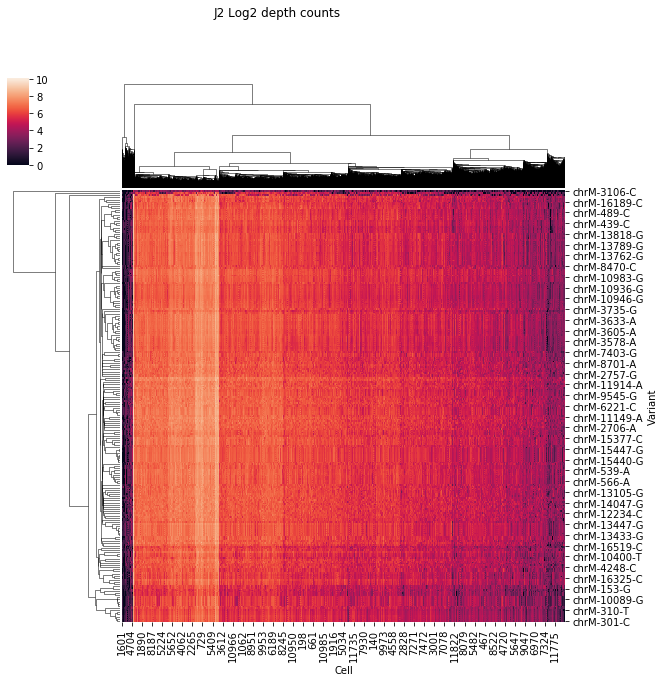

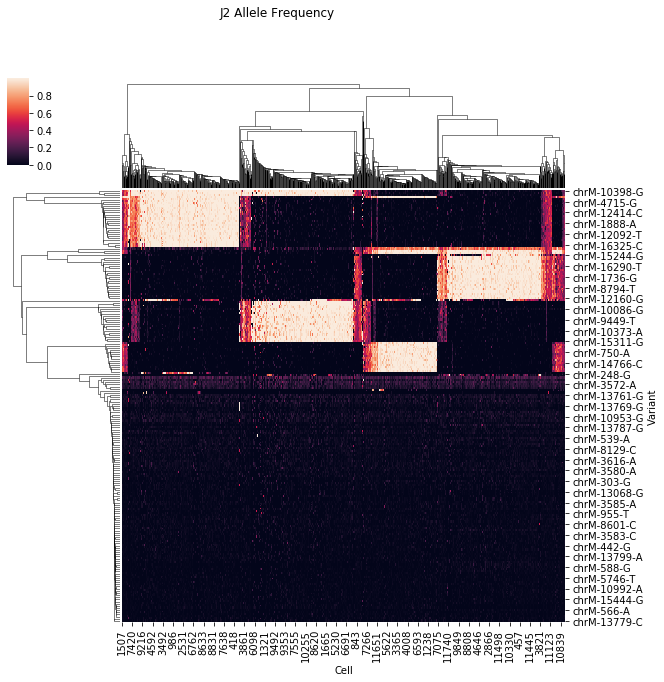

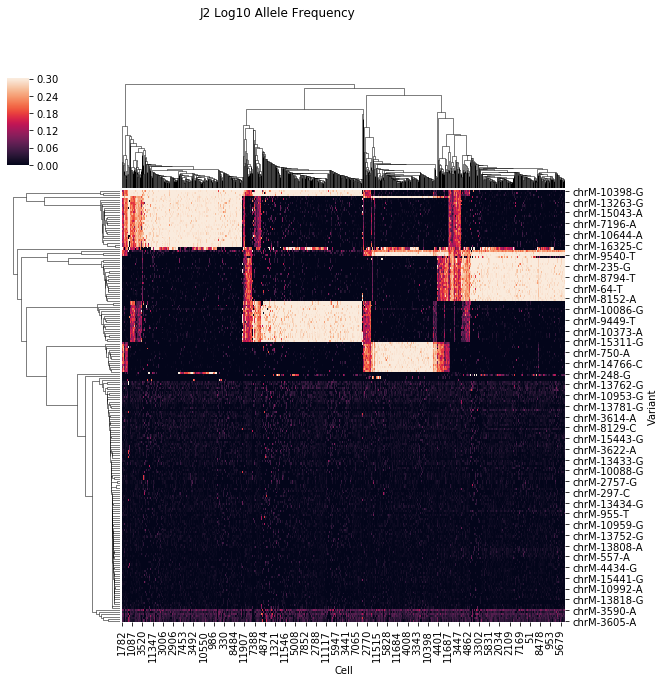

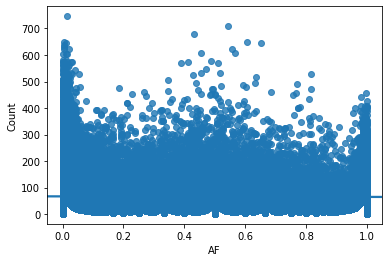

In [24]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]


minAF = 0.01
minCount = 200
curr_val = mt_counts[(mt_counts["minAF"] == minAF) & (minCount == mt_counts["minCount"])]

for ind, val in curr_val.iterrows():
    g = sns.clustermap(np.log2(1+all_dp[ind]))
    plt.suptitle(f"{val['sample']} Log2 depth counts")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")

    if all_dp[ind].shape[1] > 1000:
        inds = np.random.choice(all_dp[ind].columns, size=1000, replace=False)
    else:
        inds = all_dp[ind].column
                 
    curr_af = all_ad[ind]/(all_dp[ind]+0.0002)
    curr_af = curr_af.loc[:, inds]
    g = sns.clustermap(curr_af)
    plt.suptitle(f"{val['sample']} Allele Frequency")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")


    g = sns.clustermap(np.log10(curr_af+1))
    plt.suptitle(f"{val['sample']} Log10 Allele Frequency")
    g.ax_heatmap.set_ylabel("Variant")
    g.ax_heatmap.set_xlabel("Cell")

    
    # Correlate AF and depth
    curr_af_melt = curr_af.reset_index().melt(value_name='AF', value_vars=curr_af.columns, id_vars=["#CHROM", "POS", "ALT"])
    curr_dp_melt = all_dp[ind].loc[:, inds].melt(value_name='Count', value_vars=all_dp[ind].loc[:, inds].columns).pipe(drop_zero_count)
    
    #pd.merge(curr_af_melt, curr_dp_melt, left_index=True, right_index=True, how="inner")
    f = plt.figure()
    sns.regplot(x="AF", y="Count", data=pd.merge(curr_af_melt, 
                                                 curr_dp_melt, left_index=True, right_index=True, how="inner"))


In [25]:
def plot_heatmap_with_barplot_marginal(df, marginal_x=None, marginal_y=None):

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]
    rect_color = [left + width + spacing, bottom + height + spacing,
                  0.15, 0.15]
    # start with a square Figure
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_axes(rect_scatter)
    ax_cbar = fig.add_axes(rect_color)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)


    ax = sns.heatmap(df, ax=ax, cbar_ax=ax_cbar,xticklabels='auto',yticklabels='auto')

    if marginal_x is not None:
        marginal_x.plot.bar(rot=90, ax=ax_histx)
        ax_histx.set_xticklabels([])
    if marginal_y is not None:
        marginal_y.plot.barh(rot=90, ax=ax_histy)
        ax_histy.set_yticklabels([])
    #plot_domain(domains_2, name=None, curr_ax=ax_histx, to_transpose=True)
    #plot_domain(domains_1, name=None, curr_ax=ax_histy,to_transpose=False)
    #helper_save(f_save_fig,to_svg=False)
    return

## Merge PBMC J and P variants

In [27]:
# Change the indices of the cells
merged_af = pd.DataFrame(index=all_dp[0].index)
merged_dp = pd.DataFrame(index=all_dp[0].index)
sample_color_map = {"J2": "Blue", "P2": "Red"}
cell_color_map = {}
vars_intersection = {}
for ind, val in curr_val.iterrows():
    curr_af = all_ad[ind]/(all_dp[ind]+0.0002).copy()
    curr_dp = all_dp[ind].copy()
    vars_intersection[ind] = set(curr_dp.index)
    curr_dp.columns = map(lambda x: val['sample']+"_"+str(x), curr_dp.columns.values)
    curr_af.columns = map(lambda x: val['sample']+"_"+str(x), curr_af.columns.values)
    merged_af = pd.merge(merged_af, curr_af, left_index=True, right_index=True, how='outer')
    merged_dp = pd.merge(merged_dp, curr_dp, left_index=True, right_index=True, how='outer')
    for i in curr_dp.columns:
        cell_color_map[i] = sample_color_map[val['sample']]
merged_af = merged_af.fillna(0)
merged_dp = merged_dp.fillna(0)

In [28]:
merged_dp.sum(axis=1)

#CHROM  POS    ALT
chrM    64     T      1565005.0
        73     A      1601353.0
        146    C       817186.0
        153    G       826311.0
        185    A       700224.0
                        ...    
        16327  T      1137684.0
        16362  C       696722.0
               T       819012.0
        16463  G      1636717.0
        16519  C      1365143.0
Length: 216, dtype: float64

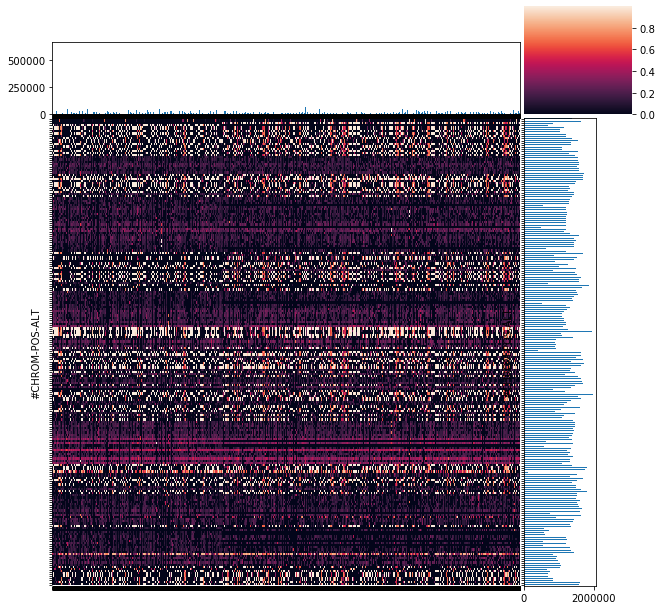

In [29]:
plot_heatmap_with_barplot_marginal(np.sqrt(merged_af.fillna(0)), 
                                   marginal_x=merged_dp.sum(axis=0), 
                                   marginal_y=merged_dp.sum(axis=1))


#merged_dp.sum(axis=1)

[]

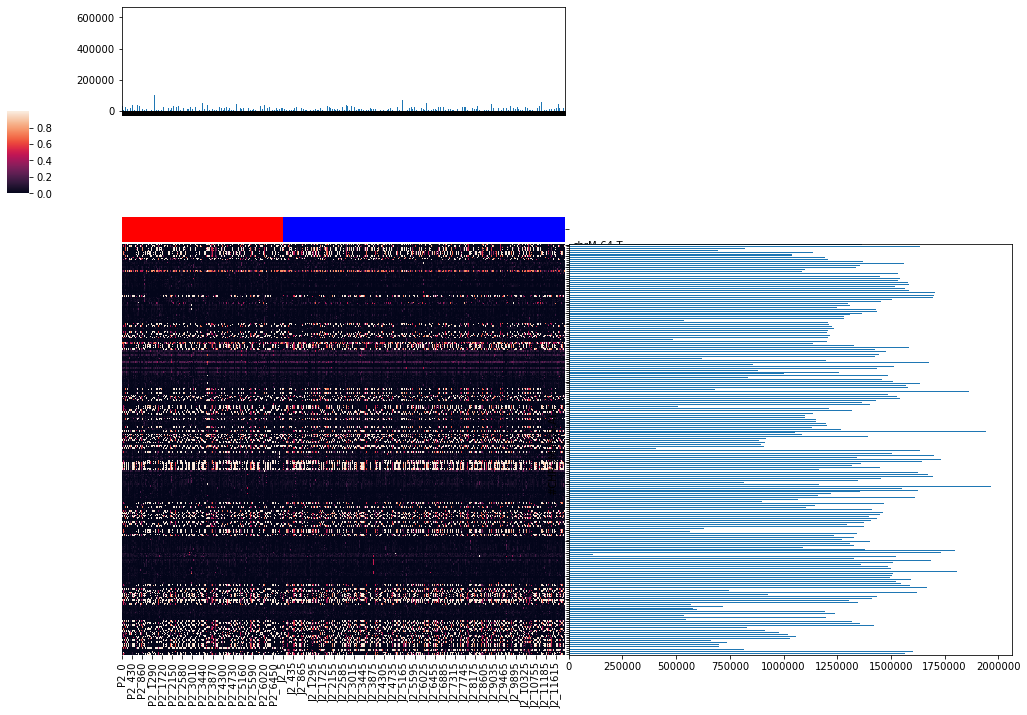

In [31]:
g = sns.clustermap(merged_af.fillna(0), col_cluster=False, row_cluster=False, col_colors=pd.Series(cell_color_map))
fig = g.fig

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
#spacing = 0.0005

# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.1]
# rect_histy = [left + width + spacing, bottom, 0.1, height]
# rect_color = [left + width + spacing, bottom + height + spacing,
#               0.15, 0.15]

rect_histx = [g.ax_heatmap.get_position().bounds[0],
              g.ax_col_dendrogram.get_position().bounds[1]+g.ax_col_dendrogram.get_position().bounds[3]+0, 
              g.ax_heatmap.get_position().bounds[2], 
              g.ax_col_dendrogram.get_position().bounds[3]]
#ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx)

merged_dp.sum(axis=0).plot.bar(rot=90, ax=ax_histx)
ax_histx.set_xticklabels([])


rect_histy = [g.ax_heatmap.get_position().bounds[0]+g.ax_heatmap.get_position().bounds[2]+spacing,
              g.ax_heatmap.get_position().bounds[1], 
              rect_histx[2],
              g.ax_heatmap.get_position().bounds[3]]
ax_histy = fig.add_axes(rect_histy)
merged_dp.sum(axis=1).plot.barh(rot=90, ax=ax_histy)
ax_histy.set_yticklabels([])

#ax_histx = fig.add_axes(rect_histx, sharex=ax)
#ax_histy = fig.add_axes(rect_histy, sharey=ax)


In [32]:
from src.external.pyvenn import venn

Text(0, 0.5, 'Overlapping Variants')

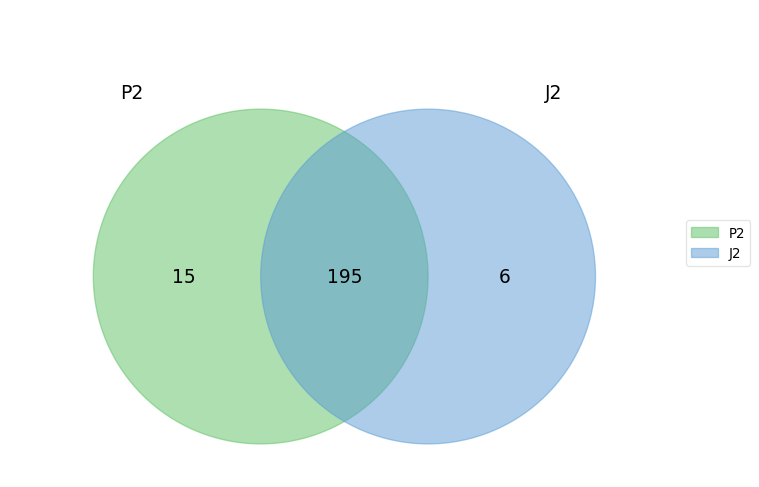

In [33]:
%matplotlib inline
labels = venn.get_labels(list(vars_intersection.values()))
venn.venn2(labels, names=list(map(lambda x: mt_counts.loc[x, "sample"], list(vars_intersection.keys()))))
plt.ylabel("Overlapping Variants")

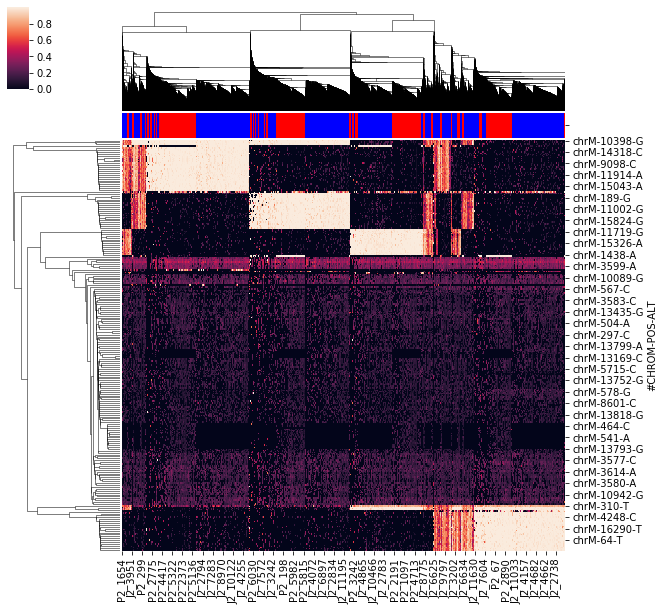

In [35]:
sns.clustermap(np.sqrt(merged_af.fillna(0)), col_cluster=True,
               col_colors=pd.Series(cell_color_map))

### Correlate low peak counts with MT expression

In [ ]:
sample = val["sample"]
peak_dir = join(config['indir'], sample, "outs", "filtered_peak_bc_matrix")
peaks = load_mtx_df_full((join(peak_dir, "matrix.mtx")), vcf_f=None)
peaks.index.name = "Peak"
peak_barcodes = pd.read_csv(join(peak_dir, "barcodes.tsv"), header=None)[0].values


## The peak ID and the pileup cell barcodes have the same order, seen here:

In [ ]:
(peak_barcodes == all_barcodes[ind]).all()

In [ ]:
cell_dp_counts = all_dp[ind].sum()
cell_peak_counts = peaks.sum()
cell_dp_peak_df = pd.concat((cell_dp_counts, cell_peak_counts), axis=1)
cell_dp_peak_df.columns=["MT Depth", "Peak Counts"]
cell_dp_peak_df

In [ ]:
sns.regplot(x="MT Depth", y="Peak Counts" , data=cell_dp_peak_df)

In [ ]:
sns.regplot(x="MT Depth", y="Peak Counts" , data=np.log10(cell_dp_peak_df))

### For each MT minCount-minAF create headmap separately for both samples

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


sample_map = {val:ind for ind, val in enumerate(mt_counts["sample"].unique())}
gs_map_row = {val:ind for ind, val in enumerate(mt_counts["minAF"].unique())}
gs_map_col = {val:ind for ind, val in enumerate(mt_counts["minCount"].unique())}

#fig = plt.figure(figsize=(10,20))
fig = plt.figure()
gs = fig.add_gridspec(len(mt_counts["minAF"].unique()),len(sample_map)*len(mt_counts["minCount"].unique()-1))

for ind, val in mt_counts.groupby(["minAF", "minCount"]):
    print('ind')
    print(val)
    curr_row = gs_map_row[ind[0]]
    curr_col = gs_map_col[ind[1]]*len(sample_map)
    for sample, val2 in val.reset_index().set_index("sample").iterrows():
        print('sample', sample)
        print("gridspec indices:")
        print(curr_row, (curr_col)+sample_map[sample])
        curr_ax = fig.add_subplot(gs[curr_row, curr_col+sample_map[sample]])
        sns.heatmap(all_ad[val2["index"]], ax=curr_ax,xticklabels=False, 
                    yticklabels=False, square=False, cbar=False)
        plt.ylabel("Variant")
        plt.xlabel("Cell")
        num_variants, num_cells = all_ad[val2["index"]].shape
        plt.title(f"{sample} \nminAF: {ind[0]}\n minCount: {ind[1]}\n #Cells: {num_cells}\n#Variants: {num_variants}")
plt.subplots_adjust(top=0.4)
plt.suptitle("Allele Frequency in MT variants called with Vireo",)
# f3_ax1 = fig3.add_subplot(gs[0, :])
# f3_ax1.set_title('gs[0, :]')
# f3_ax2 = fig3.add_subplot(gs[1, :-1])
# f3_ax2.set_title('gs[1, :-1]')
# f3_ax3 = fig3.add_subplot(gs[1:, -1])
# f3_ax3.set_title('gs[1:, -1]')
# f3_ax4 = fig3.add_subplot(gs[-1, 0])
# f3_ax4.set_title('gs[-1, 0]')
# f3_ax5 = fig3.add_subplot(gs[-1, -2])
# f3_ax5.set_title('gs[-1, -2]')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


sample_map = {val:ind for ind, val in enumerate(mt_counts["sample"].unique())}
gs_map_row = {val:ind for ind, val in enumerate(mt_counts["minAF"].unique())}
gs_map_col = {val:ind for ind, val in enumerate(mt_counts["minCount"].unique())}

fig = plt.figure(figsize=(20,20))
#fig = plt.figure()
gs = fig.add_gridspec(len(mt_counts["minAF"].unique()),len(sample_map)*len(mt_counts["minCount"].unique()-1))

for ind, val in mt_counts.groupby(["minAF", "minCount"]):
    print('ind')
    print(val)
    curr_row = gs_map_row[ind[0]]
    curr_col = gs_map_col[ind[1]]*len(sample_map)
    for sample, val2 in val.reset_index().set_index("sample").iterrows():
        print('sample', sample)
        print("gridspec indices:")
        print(curr_row, (curr_col)+sample_map[sample])
        curr_ax = fig.add_subplot(gs[curr_row, curr_col+sample_map[sample]])
        sns.heatmap(all_dp[val2["index"]], ax=curr_ax,xticklabels=False, yticklabels=False, square=False, cbar=False)
        plt.ylabel("Variant")
        plt.xlabel("Cell")
        num_variants, num_cells = all_dp[val2["index"]].shape
        plt.title(f"{sample} \nminAF: {ind[0]}\n minCount: {ind[1]}\n #Cells: {num_cells}\n#Variants: {num_variants}")
#plt.subplots_adjust(top=0.6)

plt.suptitle("Counts in MT variants called with Vireo")

In [ ]:
f = plt.figure(figsize=(10,10))
sns.clustermap(np.log2(1+all_ad[val2["index"]]), xticklabels=False, yticklabels=False)
plt.title("Log2 allele variant counts")

In [ ]:
f = plt.figure(figsize=(10,10))
sns.clustermap(np.log2(1+all_dp[val2["index"]]), xticklabels=False, yticklabels=False)
plt.title("Log2 depth counts")

In [ ]:
f = plt.figure(figsize=(10,10))
sns.clustermap(all_ad[val2["index"]]/(all_dp[val2["index"]]+0.0002), xticklabels=False, yticklabels=False)
plt.title("Allele Frequency")

In [ ]:
curr_af.reset_index()

In [ ]:
def drop_zero_count(df, col="Count"):
    return df[df[col]>0]
curr_af = all_ad[val2["index"]]/(all_dp[val2["index"]]+0.0002)
curr_af = curr_af.reset_index().melt(value_name='AF', value_vars=curr_af.columns, id_vars=["#CHROM", "POS", "ALT"])

curr_dp = all_dp[val2["index"]].melt(value_name='Count', value_vars=all_dp[val2["index"]].columns).pipe(drop_zero_count)
curr_dp

In [ ]:
curr_af

In [ ]:
pd.merge(curr_af, curr_dp, left_index=True, right_index=True, how="inner")

sns.regplot(x="AF", y="Count", data=pd.merge(curr_af, curr_dp, left_index=True, right_index=True, how="inner"))

### Variants

In [ ]:
variant_counts = pd.DataFrame(product(config["samples"], config["pre_variant"]["minCOUNT"], 
                                      config["pre_variant"]["minMAF"]), 
                                columns=["sample", "minCount", "minAF"])
#{"Donor": [], "mt_minAF": [], "mt_minCount":[], "minAF":[], "minCount":[]}
all_ad = {}
all_dp = {}
all_vcf = {}
#for sample, minCount, minAF in product(config["samples"], config["mt"]["minCOUNT"], config["mt"]["minMAF"]):    
for ind, val in variant_counts.iterrows():
    curr_dir = f"data/{val['sample']}_cellSNP_minC{val['minCount']}_minAF{val['minAF']}/"
    print(curr_dir)
    dp, ad, vcf = load_pileup(curr_dir)
    all_ad[ind] = ad
    all_dp[ind] = dp
    all_vcf[ind] = vcf
variant_counts

### Load and process input data

In [ ]:
for ind, val in mt_counts.iterrows():
    print(ind)
    DP_df = pd.DataFrame(DP.todense())
    DP_df.index.name = "Variant"
    DP_df.columns.name = "Cell"
    AD_df.index.name = "Variant"
    AD_df.columns.name = "Cell"

    print("AD shape", AD_df.shape)
    print("DP shape", DP_df.shape)
    AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    DP_df = pd.merge(DP_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    AD_df

In [ ]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
vcf = pd.read_csv(VCF_F, sep='\t', skiprows=1)
AD_df = pd.DataFrame(AD.todense())
DP_df = pd.DataFrame(DP.todense())
DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AD_df.index.name = "Variant"
AD_df.columns.name = "Cell"

print("AD shape", AD_df.shape)
print("DP shape", DP_df.shape)
AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
DP_df = pd.merge(DP_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
AD_df

## Create Allele Frequency as AD/(DP+0.001) 

In [ ]:
AF_df = AD_df/(DP_df+0.001)
g = sns.clustermap(AF_df)
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

## Log 10

In [ ]:
AF_df = AD_df/(DP_df+0.001)

g = sns.clustermap(np.log10(AF_df+1))
g.fig.suptitle("Log10(Allele frequency+1)")
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

## Depth

In [ ]:
#AF_df = AD_df/(DP_df+0.001)
g = sns.clustermap(np.log10(DP_df+1))
g.fig.suptitle("Depth")
g.ax_heatmap.set_xlabel("Cell")
g.ax_heatmap.set_ylabel("Variant")
#plt.xlabel("Cell")

### There shouldnt be cells and variants that are undetected, but we see that below for both Allele Frequencies and read depth

In [ ]:
print(f"Number of cells with no variants detected: {(AF_df == 0).all(axis=0).sum()}")
print(f"Number of variants with no cells having coverage: {(AF_df == 0).all(axis=1).sum()}")

In [ ]:
print(f"Number of cells with no variants detected: {(DP_df == 0).all(axis=0).sum()}")
print(f"Number of variants with no cells having coverage: {(DP_df == 0).all(axis=1).sum()}")

## Remove the 0s in both areas

In [ ]:
def remove_zeros(df, multi_index=False):
    if multi_index:
        df.index = list(map(lambda x: "_".join(np.array(x)), DP_df.index))
    df = df.loc[~((AF_df==0).all(axis=1)),:]
    df = df.loc[:, ~((AF_df==0).all(axis=0))]
    return df

AF_df_filt = remove_zeros(AF_df)
DP_df_filt = remove_zeros(DP_df)

print("After removing variants and cells with all 0s")
print(f"Number of variants left are {AF_df_filt.shape[0]}")
print(f"Number of cells left are {AF_df_filt.shape[1]}")